## About
This program backtests the RSI trading strategy.
- Entry: 10-period RSI below 30 and the price is above the 200-day moving average (buy on the nex day's open).
- Exit: 10-period RSI above 40 or after 10 trading days (sell on the next day's open).

## Import modules

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
help(ta.rsi)

Help on function rsi in module pandas_ta.momentum.rsi:

rsi(close, length=None, scalar=None, talib=None, drift=None, offset=None, **kwargs)
    Relative Strength Index (RSI)
    
    The Relative Strength Index is popular momentum oscillator used to measure the
    velocity as well as the magnitude of directional price movements.
    
    Sources:
        https://www.tradingview.com/wiki/Relative_Strength_Index_(RSI)
    
    Calculation:
        Default Inputs:
            length=14, scalar=100, drift=1
        ABS = Absolute Value
        RMA = Rolling Moving Average
    
        diff = close.diff(drift)
        positive = diff if diff > 0 else 0
        negative = diff if diff < 0 else 0
    
        pos_avg = RMA(positive, length)
        neg_avg = ABS(RMA(negative, length))
    
        RSI = scalar * pos_avg / (pos_avg + neg_avg)
    
    Args:
        close (pd.Series): Series of 'close's
        length (int): It's period. Default: 14
        scalar (float): How much to magnify.

## Define the functions for the strategy

In [3]:
def get_signal_rsi(close, max_hold_days=10, min_rsi=30,
                   max_rsi=40, length_rsi=10, length_sma=200):
    """
    Pass in a time series of closing price, optional maximum holding days, 
    minimum and the maximum rsi (relative strength index) for entering and exiting, 
    the window for calculating the rsi, and the length for the simple moving average, 
    returns the buying and selling dates.
    RSI trading strategy:
    - Entry: 10-period RSI below 30 and the price is above the 200-day moving average (buy on the nex day's open).
    - Exit: 10-period RSI above 40 or after 10 trading days (sell on the next day's open).   
    """    
    buy_date = []
    sell_date = []
    
    # Make sure that it has enough data
    if (len(close) > length_sma+max_hold_days+1):  
        # Calculate RSI and the standard moving average
        df = pd.DataFrame({'Close': close})
        df['RSI'] = ta.rsi(df['Close'], length=length_rsi)
        df['SMA'] = ta.sma(df['Close'], length=length_sma)
        # Replace None with NaN
        df = df.fillna(value=np.nan)
        
        # Get the buying signal
        df['Signal'] = np.where((df['Close'] > df['SMA']) \
                              & (df['RSI'] < min_rsi), True, False)
        
        # Get the buying and selling dates
        for i in range(len(df['Signal']) - (max_hold_days+1)):
            if df['Signal'].iloc[i] == True: 
                # Buy tomorrow
                buy_date.append(df['Signal'].index[i+1])
                # Sell if the maximum holding day has been reached or
                # RSI is above max_rsi on the next day
                for j in range(1,max_hold_days+1):
                    if df['RSI'].iloc[i+j] > max_rsi:
                        sell_date.append(df['Signal'].index[i+j+1])
                        break                       
                    elif j == max_hold_days:
                        sell_date.append(df['Signal'].index[i+j+1])
                    
    # Avoid overlapping position
    df2 = pd.DataFrame({'buy date':buy_date, 'sell date':sell_date})
    no_ovlp = df2[df2['buy date'] > df2['sell date'].shift(1)]
    # Add the first trade
    no_ovlp = df2[:1].append(no_ovlp)
    return no_ovlp['buy date'], no_ovlp['sell date']

## Define the functions for backtesting

In [4]:
def backtest_strategy(tickers, hist, start_date, end_date):
    """
    Pass in a list of ticker symbols, a dataframe containing the time series of
    closing price of each symbol, start and end dates, returns a matrix
    containing the profit/loss from each transaction and a matrix containing 
    the holding periods from each transaction.
    """ 
    matrixprofits = []
    matrixholddays = []
    for t in tickers:
        df = pd.DataFrame(hist[t].dropna())
        if (len(df) > 0):
            # Remove rows with duplicated indices
            df = df[~df.index.duplicated(keep='first')]
            
            # Obtain the buying and selling dates using Bollinger Band strategy
            buy_date, sell_date = get_signal_rsi(df['Close'].dropna())
            
            # Store the average holding period
            hold_day = []
            for buy, sell in zip(buy_date, sell_date):
                hold_day.append(sell - buy)
            matrixholddays.append(hold_day)

            # Fetch the buying and selling prices
            buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'], 
                                     'Sell': df.loc[sell_date,'Open']})
            buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
            buy_sell.dropna(inplace=True)
            buy_sell = buy_sell.loc[start_date:end_date]

            # Store the profits
            profit = (buy_sell['Sell'] - buy_sell['Buy'])/buy_sell['Buy']
            matrixprofits.append(profit.values)

    return matrixprofits, matrixholddays

In [5]:
def calc_backtest_profit(matrixprofits, cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]        
        
    win = [i for i in allprofit if i > 0]
    loss = [i for i in allprofit if i < 0]
    prob_win = len(win)/(len(allprofit)+1e-6)
    kelly = prob_win-((1-prob_win)/
                      (np.mean(win)/np.absolute(np.mean(loss))))
    print(f'Number of transactions: {len(allprofit)}')    
    print(f'Winning probability: {np.round(100*prob_win, 2)}%')
    print(f'Mean return: {np.round(100*np.mean(allprofit), 2)}%')
    print(f'Mean profit: {np.round(100*np.mean(win), 2)}%')
    print(f'Mean loss: {np.round(100*np.mean(loss), 2)}%')    
    print(f'Kelly criterion: {np.round(100*kelly, 2)}%')    

In [6]:
def calc_backtest_effective_annual_return(matrixprofits, matrixholddays, 
                                          cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]        

    # Average holding days
    allholdday = []
    for e in matrixholddays:
        for i in e:
            allholdday.append(i.days)
    print(f'Mean holding period: {np.round(np.mean(allholdday),2)} days')
    
    # Effective annual return
    ann_return = 100* np.round(np.power(1+np.mean(allprofit),
                                        365/np.mean(allholdday))-1, 2)
    print(f'Annual effective return: {ann_return}%')

In [7]:
def calc_backtest_bet_return(matrixprofits, one_bet=100, 
                             cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]
    
    returns = 0
    for profit in allprofit:
        returns = returns + (one_bet*profit)
    print(f'If you follow the trading strategy and put {one_bet} USD for each transaction,')
    print(f'Your profit will be {np.round(returns)} USD after {len(allprofit)} number of transactions')        

In [8]:
def plot_backtest_profit_hist(matrixprofits, matrixholddays, 
                              cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]  

    # Percent profit
    allprofit = np.dot(100,allprofit)
    hist = np.histogram(allprofit, bins='auto')
    median = np.median(allprofit)
    mode = hist[1][np.argmax(hist[0])]
    plt.figure(figsize=(10,4))
    plt.hist(allprofit, bins='auto')
    plt.axvline(x=median, lw=4, ls='-.', label='median = '+ str(round(median, 1)), c='orange')
    plt.axvline(x=mode, lw=4, label='mode = '+ str(round(mode, 1)), c='red')
    plt.xlabel('Percentage return',fontsize=13)
    plt.ylabel('Counts',fontsize=13)
    plt.title('Distribution of the percentage return of all transactions')
    plt.legend();
    plt.show();

In [9]:
def calc_effective_annual_return(close, name='the asset'):
    profit = (close.iloc[-1] - close.iloc[0])/close.iloc[0]
    holdday = (close.index[-1] - close.index[0]).days
    ann_return = np.power(1+profit, (365/holdday))-1
    print(f'The effective annual return of {name} is {np.round(100*ann_return,2)}%')

## Backtest one asset

#### Download the historical data

In [10]:
ticker = 'MU'

In [11]:
start_date = datetime.now() - relativedelta(years=3)
start_date = start_date.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))

In [12]:
df = yf.download(ticker, start=start_date, end=end_date)
df_ori = df.copy()
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-27,51.349998,52.450001,51.169998,52.070000,52.070000,29134100
2018-08-28,52.419998,52.560001,51.470001,52.340000,52.340000,26198800
2018-08-29,52.090000,52.160000,51.299999,51.830002,51.830002,31450800
2018-08-30,51.560001,53.680000,51.400002,52.759998,52.759998,32416600
2018-08-31,52.700001,53.230000,52.220001,52.520000,52.520000,29937300
...,...,...,...,...,...,...
2021-08-19,70.139999,70.820000,69.040001,70.279999,70.279999,18022600
2021-08-20,70.139999,71.029999,69.580002,70.230003,70.230003,14594200
2021-08-23,70.839996,71.879997,68.900002,71.739998,71.739998,22265000


#### Perform the backtesting

In [13]:
df = df_ori.copy()
buy_date, sell_date = get_signal_rsi(df['Close'])

#### Plot the results

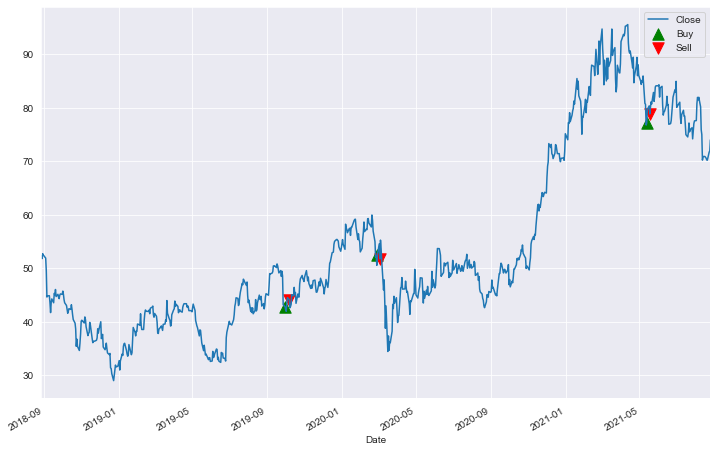

In [14]:
ax = df['Close'].plot(figsize=(12,8))
ax.scatter(buy_date, df.loc[buy_date].Close, marker='^', c='g', s=130, label='Buy')
ax.scatter(sell_date, df.loc[sell_date].Close, marker='v', c='r', s=130, label='Sell');
ax.autoscale(tight=True, axis='x');
ax.legend()
ax.grid;

#### Calculate the profit

In [15]:
buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'], 
                         'Sell': df.loc[sell_date,'Open']})
buy_sell.tail(5)

,Buy,Sell
Date,,
2019-10-07,NaN,44.299999
2020-02-28,48.650002,NaN
2020-03-03,NaN,54.599998
2021-05-13,77.970001,NaN
2021-05-18,NaN,80.550003


In [16]:
buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
buy_sell.dropna(inplace=True)

In [17]:
profit = (buy_sell.Sell - buy_sell.Buy)/buy_sell.Buy
win = [i for i in profit if i > 0]
pct_win = 100*len(win)/(len(profit)+1e-6)
print(f'Winning percentage: {np.round(pct_win, 2)}%')
print(f'Mean profit: {np.round(np.mean(profit*100), 2)}%')
print(f'Number of transactions: {len(profit)}')

Winning percentage: 100.0%
Mean profit: 6.19%
Number of transactions: 3


In [18]:
ret = (1 + profit).cumprod()
ret

Date
2019-09-30    1.030233
2020-02-28    1.156232
2021-05-13    1.194491
dtype: float64

In [19]:
# Store the average holding period
hold_day = []
for buy, sell in zip(buy_date, sell_date):
    hold_day.append(sell - buy)
print(f'Mean holding period: {np.mean(hold_day)}')

Mean holding period: 5 days 08:00:00


## Backtest multiple assets

#### Set the ticker symbols

In [20]:
stocks = pd.read_csv('data/nasdaq_screener_1626347395770.csv', index_col=0)
market_cap_lim = 5e10
stocks = stocks[stocks['Market Cap'] > market_cap_lim]

In [21]:
tickers = list(stocks.index)

In [22]:
add_list = ['ARKK', 'ARKG', 'ARKF', 'ARKW', 'ARKQ', '^GSPC', '^IXIC', 'ETH-USD', 'BTC-USD']
tickers.extend(add_list)
len(tickers)

249

In [23]:
# remove weird data
unwanted_list = ['GE','TTE']
tickers = [t for t in tickers if t not in unwanted_list]
len(tickers)

247

In [24]:
benchmark = ['^GSPC', '^IXIC']

#### Obtain the historical data

In [25]:
hist_ori = pd.read_csv('data/historical_data_from_2015.csv', index_col=0, header=[0,1], parse_dates=True)

#### Perform the backtesting

In [26]:
start_date = datetime.now() - relativedelta(years=5)
data_start = start_date - relativedelta(years=1)
start_date = start_date.strftime('%Y-%m-%d')
data_start = data_start.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))
data_start, start_date, end_date

('2015-08-26', '2016-08-26', '2021-08-26')

In [27]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is 15.46%
The effective annual return of ^IXIC is 23.11%


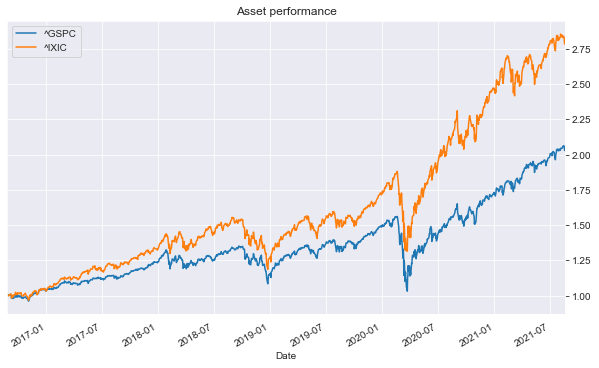

In [28]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

rsi-------------------------------------------
Number of transactions: 1582
Winning probability: 74.27%
Mean return: 1.24%
Mean profit: 3.02%
Mean loss: -3.95%
Kelly criterion: 40.69%
Mean holding period: 6.94 days
Annual effective return: 91.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 1955.0 USD after 1582 number of transactions


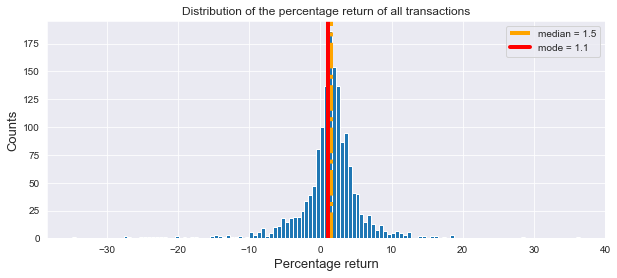

rsi cut_loss----------------------------------
Number of transactions: 1582
Winning probability: 74.27%
Mean return: 1.59%
Mean profit: 3.02%
Mean loss: -2.55%
Kelly criterion: 52.56%
Mean holding period: 6.94 days
Annual effective return: 130.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 2520.0 USD after 1582 number of transactions


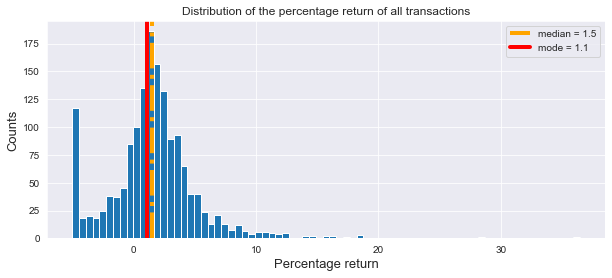

In [29]:
st = 'rsi'
print(f'{st}-------------------------------------------')
matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date)
calc_backtest_profit(matrixprofits)
calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
calc_backtest_bet_return(matrixprofits, one_bet=100)
plot_backtest_profit_hist(matrixprofits, matrixholddays)
print(f'{st} cut_loss----------------------------------')
calc_backtest_profit(matrixprofits, cut_loss=-0.05)
calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)